In [10]:
# Import necessary libraries
import os                        # Library to interact with the operating system
import cv2                       # OpenCV library for computer vision tasks
import numpy as np               # NumPy library for numerical operations
from sklearn.datasets import fetch_lfw_people   # Function to load the LFW dataset
from sklearn.model_selection import train_test_split   # Function to split dataset into train and test subsets

# # Function to split augmented dataset into training and testing subsets
# def split_augmented_dataset(augmented_dir, test_size=0.2):
#     # Get the list of label names (subdirectories in augmented_dir)
#     label_names = os.listdir(augmented_dir)   # Fetch the names of subdirectories in the augmented dataset
#     images = []   # Initialize an empty list to store images
#     labels = []   # Initialize an empty list to store corresponding labels

#     # Loop through each label and read images from subdirectories
#     for label_idx, label_name in enumerate(label_names):
#         label_dir = os.path.join(augmented_dir, label_name)   # Create the full path of the label subdirectory
#         for image_file in os.listdir(label_dir):   # Loop through each image file in the subdirectory
#             image_path = os.path.join(label_dir, image_file)   # Create the full path of the image file
#             image = cv2.imread(image_path)   # Read the image using OpenCV
#             try:
#                 if image.ndim == 2:  # Grayscale image
#                     # Convert the grayscale image to RGB format
#                     image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)
#                 images.append(image)   # Append the image to the images list
#                 labels.append(label_idx)   # Append the corresponding label to the labels list
#             except:
#                 pass
#     images = np.stack(images, axis=0)
#     # images = np.array(images)   # Convert the list of images to a NumPy array
#     labels = np.array(labels)   # Convert the list of labels to a NumPy array
#     print(images.shape)
#     print(labels.shape)

#     # Split the images and labels into training and testing subsets
#     X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=test_size, random_state=42)   # Split using sklearn's train_test_split
#     return X_train, X_test, y_train, y_test   # Return the training and testing subsets of images and labels

In [11]:
# Function to perform image augmentation using OpenCV
def augment_image(image):
    # Check if the image is grayscale (2-dimensional)
    if image.ndim == 2:  # Grayscale image
        # Convert the grayscale image to RGB format
        image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)

    rows, cols, _ = image.shape   # Get the dimensions of the image

    # Random rotation between -10 to 10 degrees
    random_angle = np.random.randint(-10, 11)   # Generate a random angle between -10 and 10 degrees
    M = cv2.getRotationMatrix2D((cols / 2, rows / 2), random_angle, 1)   # Get the rotation matrix for the random angle
    augmented_image = cv2.warpAffine(image, M, (cols, rows))   # Apply the rotation to the image using warpAffine

    # Random horizontal flipping
    if np.random.rand() > 0.5:   # Generate a random number between 0 and 1, and check if it's greater than 0.5
        flipped_image = cv2.flip(augmented_image, 1)  # 1 means horizontal flip. Flip the image horizontally
    else:
        flipped_image = augmented_image   # Keep the image as is (no horizontal flip)

    # Random brightness adjustment
    brightness_factor = np.random.uniform(0.7, 1.3)   # Generate a random brightness factor between 0.7 and 1.3
    hsv_image = cv2.cvtColor(flipped_image, cv2.COLOR_RGB2HSV)   # Convert the RGB image to HSV color space
    hsv_image[:, :, 2] = hsv_image[:, :, 2] * brightness_factor   # Adjust the brightness (V channel) by the brightness factor
    augmented_image = cv2.cvtColor(hsv_image, cv2.COLOR_HSV2RGB)   # Convert the HSV image back to RGB color space

    return augmented_image   # Return the augmented image

In [12]:
def augment_lfw_people_dataset(lfw_people, target_count=10, output_directory='lfw_augmented'):
    # Create a new directory for the augmented dataset
    augmented_dir = os.path.join(lfw_people.target_names[0], output_directory)   # Create the full path of the augmented directory
    os.makedirs(augmented_dir, exist_ok=True)   # Create the augmented directory if it doesn't exist

    # Loop through each label in the dataset
    for label_idx, label_name in enumerate(lfw_people.target_names):
        label_dir = os.path.join(augmented_dir, label_name)   # Create the full path of the label subdirectory
        os.makedirs(label_dir, exist_ok=True)   # Create the label subdirectory if it doesn't exist

        # Get images belonging to the current label
        label_images = lfw_people.images[lfw_people.target == label_idx]   # Fetch the images with the current label

        # Check if the label folder already has enough images (>= target_count)
        if len(label_images) >= target_count:   # If the label already has enough images
            selected_images = label_images[:target_count]   # Select the first target_count number of images
        else:
            # If the label folder has fewer images, duplicate and augment the existing images
            selected_images = []
            while len(selected_images) < target_count:
                for image in label_images:
                    selected_images.append(image)   # Augment the image and add to selected_images
                    if len(selected_images) == target_count:   # Check if we have enough augmented images
                        break

        # Perform augmentation for images with count < target_count
        for idx, image in enumerate(selected_images):
            image_path = os.path.join(label_dir, f'{label_name}_{idx}.png')   # Create the full path of the augmented image
            image = cv2.convertScaleAbs(image, alpha=(255.0))
            cv2.imwrite(image_path, image)   # Write the augmented image to the specified path

In [15]:
# Load the LFW dataset
lfw_people = fetch_lfw_people(min_faces_per_person=4, resize=0.4)   # Fetch the LFW dataset with specified parameters

# Augment the LFW dataset
augment_lfw_people_dataset(lfw_people, target_count=10)   # Augment the dataset with 10 images per class

In [16]:
#This is splitting code:
import os
import shutil
import random

# Define the directory containing your data
data_directory = './Aaron Peirsol/lfw_augmented'

# Define the output directories for training and test data
train_directory = 'training_data'
test_directory = 'test_data'

# Create the output directories if they don't exist
os.makedirs(train_directory, exist_ok=True)
os.makedirs(test_directory, exist_ok=True)

# Loop through each person's data directory
for person_dir in os.listdir(data_directory):
    person_path = os.path.join(data_directory, person_dir)

    # Get all the image filenames in the person's directory
    image_files = [f for f in os.listdir(person_path) if f.endswith('.png')]

    # Shuffle the image files randomly
    random.shuffle(image_files)

    # Calculate the split index for training and test sets
    split_index = int(0.8 * len(image_files))

    # Split the image files into training and test sets
    train_images = image_files[:split_index]
    test_images = image_files[split_index:]

    # Move the training images to the training data directory
    for train_img in train_images:
        src = os.path.join(person_path, train_img)
        # dest = os.path.join(train_directory, person_dir, train_img)
        
        dest_dir = os.path.join(train_directory, person_dir)
        dest_dir = dest_dir.replace(" ", "_")
        dest = os.path.join(dest_dir, train_img)
        os.makedirs(dest_dir, exist_ok=True)
        shutil.copy(src, dest)

    # Move the test images to the test data directory
    for test_img in test_images:
        src = os.path.join(person_path, test_img)
        # dest = dest.replace(" ", "_")
        dest_dir = os.path.join(test_directory, person_dir)
        dest_dir = dest_dir.replace(" ", "_")
        dest = os.path.join(dest_dir, test_img)
        os.makedirs(dest_dir, exist_ok=True)
        shutil.copy(src, dest)

print("Data split completed successfully!")

Data split completed successfully!


In [17]:
# Reading the images
# Define the output directories for training and test data
train_directory = 'training_data'
test_directory = 'test_data'

In [18]:
# Define the output directories for training and test data
train_directory = './training_data'
test_directory = './test_data'

x_train = []
y_train = []
# Loop through train data
for person_dir in os.listdir(train_directory):
    train_image = os.path.join(train_directory, person_dir)
    # Get all the image filenames in the person's directory
    image_files = [f for f in os.listdir(train_image) if f.endswith('.png')]
    x_train.extend(image_files)
    for label in image_files:
        y_train.append(person_dir)
    # label_image.extend(temp_label)

In [19]:
import numpy as np

In [20]:
from PIL import Image
arr = []
for idx, image_path in enumerate(x_train):
    image_path = f"./training_data/{y_train[idx]}/"+image_path
    image = Image.open(image_path)
    arr.append(np.asarray(image))
x_train = np.array(arr)

In [21]:
x_test = []
y_test = []
# Loop through train data
for person_dir in os.listdir(test_directory):
    test_image = os.path.join(test_directory, person_dir)
    # Get all the image filenames in the person's directory
    image_files = [f for f in os.listdir(test_image) if f.endswith('.png')]
    x_test.extend(image_files)
    for label in image_files:
        y_test.append(person_dir)
    # label_image.extend(temp_label)
    
arr = []
for idx, image_path in enumerate(x_test):
    image_path = f"./test_data/{y_test[idx]}/"+image_path
    image = Image.open(image_path)
    arr.append(np.asarray(image))
x_test = np.array(arr)

In [22]:
x_test.shape, len(y_test)

((1220, 50, 37), 1220)

In [23]:
x_train.shape, len(y_train)

((4880, 50, 37), 4880)

In [24]:
# X_train = X_train.reshape(-1, 50 * 37 * 3)
# X_test = X_test.reshape(-1, 50 * 37 * 3)

In [25]:
from skimage.feature import hog, local_binary_pattern
import xgboost as xgb
from sklearn.metrics import classification_report, accuracy_score
from skimage import exposure
  
def scale_invariant_feature_transform(image):
    
    image = cv2.cvtColor(image,cv2.COLOR_GRAY2RGB)
    
    # Convert the image depth to CV_8U
    image8bit = cv2.normalize(image, None, 0, 255, cv2.NORM_MINMAX).astype('uint8')
    
    #reading image
    gray1 = cv2.cvtColor(image8bit, cv2.COLOR_BGR2GRAY)
    
    #keypoints
    #keypoints``
    sift = cv2.SIFT_create()
    keypoints_1, descriptors_1 = sift.detectAndCompute(gray1, None)

    img_1 = cv2.drawKeypoints(gray1,keypoints_1,image)
    return img_1
    
def local_binary_patterns(image):
    
    # settings for LBP
    radius = 3
    n_points = 8 * radius
    
    image = cv2.cvtColor(image,cv2.COLOR_GRAY2RGB)
    
    # Convert the image depth to CV_8U
    image8bit = cv2.normalize(image, None, 0, 255, cv2.NORM_MINMAX).astype('uint8')

    # Convert the array to grayscale and reshape it to (height, width)
    gray1 = cv2.cvtColor(image8bit, cv2.COLOR_BGR2GRAY)

    lbp = local_binary_pattern(gray1, n_points, radius, method = "uniform")

    return lbp

# Function to extract combined features (HOG, SIFT, and LBP) from an image
def extract_combined_features(image):
    sift_features = scale_invariant_feature_transform(image)
    lbp_features = local_binary_patterns(image)
    
    sift_features = sift_features.flatten()
    lbp_features = lbp_features.flatten()
    
    merged_feature = np.hstack((sift_features,lbp_features))
    return merged_feature
    

In [26]:
# Extract combined features from the training and testing images
X_train_features = np.array([extract_combined_features(image) for image in x_train])
X_test_features = np.array([extract_combined_features(image) for image in x_test])

In [27]:
X_train_features.shape

(4880, 7400)

In [28]:
from time import time
from sklearn.decomposition import PCA
def pca_implementation(X_train, X_test):
    # Compute a PCA (eigenfaces) on the face dataset (treated as unlabeled
    # dataset): unsupervised feature extraction / dimensionality reduction
    n_components = 60

    print("Extracting the top %d eigenfaces from %d faces"
          % (n_components, X_train.shape[0]))
    t0 = time()
    pca = PCA(n_components=n_components, svd_solver='randomized',
              whiten=True).fit(X_train)
    print("done in %0.3fs" % (time() - t0))

    print("Projecting the input data on the eigenfaces orthonormal basis")
    t0 = time()
    X_train_pca = pca.transform(X_train)
    X_test_pca = pca.transform(X_test)
    print("done in %0.3fs" % (time() - t0))
    return X_train_pca, X_test_pca

In [29]:
X_train, X_test= pca_implementation(X_train_features, X_test_features)

Extracting the top 60 eigenfaces from 4880 faces
done in 5.066s
Projecting the input data on the eigenfaces orthonormal basis
done in 0.354s


In [30]:
X_train.shape

(4880, 60)

In [31]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
yy_train = le.fit_transform(y_train)

In [32]:
yy_test = le.fit_transform(y_test)

In [33]:
yy_test.shape, yy_train.shape

((1220,), (4880,))

In [34]:
# Train an XGBoost model
model = xgb.XGBClassifier(n_estimators=250,
                          max_depth=8,
                          objective= 'binary:logistic',
                          seed=27, 
                          tree_method='gpu_hist', gpu_id=0)
model.fit(X_train, yy_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=0, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=8, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=250, n_jobs=None, num_parallel_tree=None,
              objective='multi:softprob', predictor=None, ...)

In [35]:
X_test.shape

(1220, 60)

In [36]:
# Predict using the XGBoost model
y_pred = model.predict(X_test)

In [37]:
accuracy = accuracy_score(yy_test, y_pred)

# Print the results
print("Accuracy Score:", accuracy)

Accuracy Score: 0.22049180327868853


In [38]:
print("Classification Report:")
# Calculate classification report and accuracy score
classification_report_output = classification_report(yy_test, y_pred)
print(classification_report_output)

Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         2
           1       0.25      0.50      0.33         2
           2       0.33      0.50      0.40         2
           3       0.00      0.00      0.00         2
           4       1.00      0.50      0.67         2
           5       0.33      0.50      0.40         2
           6       0.00      0.00      0.00         2
           7       0.50      0.50      0.50         2
           8       0.00      0.00      0.00         2
           9       0.00      0.00      0.00         2
          10       0.25      0.50      0.33         2
          11       1.00      0.50      0.67         2
          12       0.00      0.00      0.00         2
          13       0.00      0.00      0.00         2
          14       0.00      0.00      0.00         2
          15       1.00      0.50      0.67         2
          16       1.00      1.00      1.00         2
    

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [30]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

In [20]:
y_pred_prob = model.predict_proba(X_test)

In [23]:
y_pred_prob_1 = y_pred_prob[:,1]

In [25]:
y_pred_prob.shape, y_pred_prob_1.shape

((1220, 610), (1220,))

In [26]:
# generate a no skill prediction (majority class)
ns_probs = [0 for _ in range(len(y_test))]

In [28]:
len(ns_probs)

1220

In [31]:
# calculate scores
ns_auc = roc_auc_score(y_test, ns_probs)
lr_auc = roc_auc_score(y_test, y_pred_prob_1)

ValueError: multi_class must be in ('ovo', 'ovr')

In [ ]:
# summarize scores
print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('Logistic: ROC AUC=%.3f' % (lr_auc))

In [ ]:
# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(testy, ns_probs)
lr_fpr, lr_tpr, _ = roc_curve(testy, lr_probs)

In [ ]:
# plot the roc curve for the model
pyplot.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
pyplot.plot(lr_fpr, lr_tpr, marker='.', label='Logistic')
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

In [32]:
from sklearn.preprocessing import LabelBinarizer

label_binarizer = LabelBinarizer().fit(y_train)
y_onehot_test = label_binarizer.transform(y_test)
y_onehot_test.shape  # (n_samples, n_classes)

(1220, 610)

In [35]:
list(lfw_people.target_names).index("George W Bush")

187

In [36]:
label_binarizer.transform([187])

array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

In [37]:
class_of_interest = 187
class_id = np.flatnonzero(label_binarizer.classes_ == class_of_interest)[0]
class_id

187

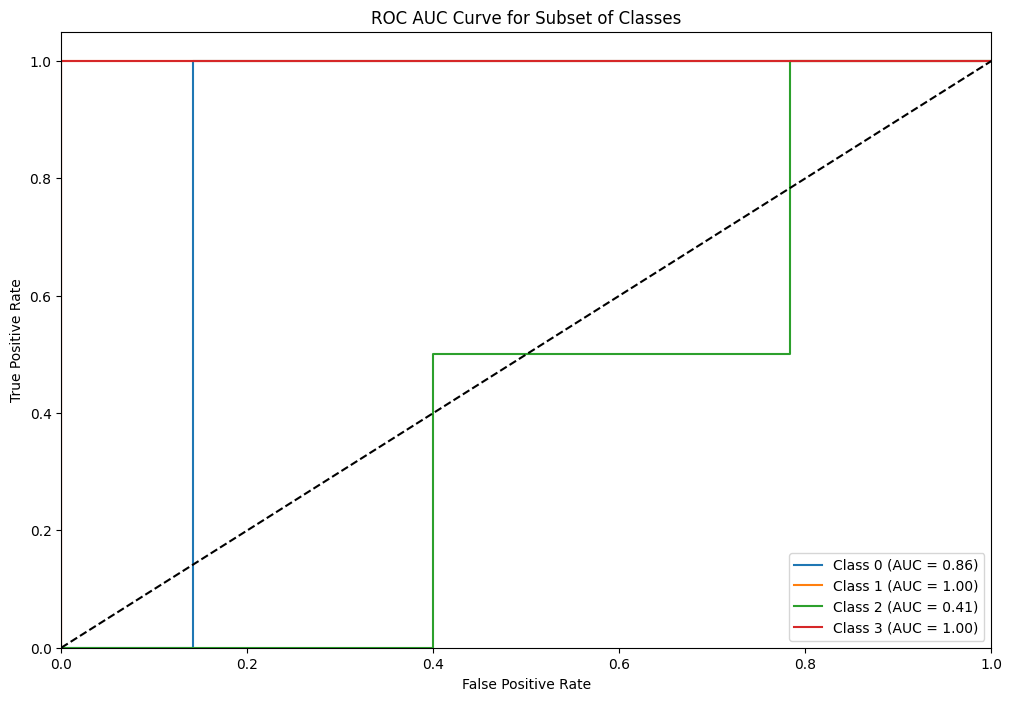

In [44]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, auc


# Specify the subset of classes to plot
subset_classes = [0, 1, 2, 3]  # Replace with the class indices you want to plot

# Calculate ROC curves and AUC scores for the subset of classes
fpr = {}
tpr = {}
roc_auc = {}
for i in subset_classes:
    fpr[i], tpr[i], _ = roc_curve(y_onehot_test[:, i], model.predict_proba(X_test)[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curves for the subset of classes
plt.figure(figsize=(12, 8))
for i in subset_classes:
    plt.plot(fpr[i], tpr[i], label='Class %d (AUC = %0.2f)' % (i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC AUC Curve for Subset of Classes')
plt.legend(loc="lower right")
plt.show()

In [43]:
y_test

array([279, 259, 535, ...,  73, 197, 116])